## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

## Download a dataset

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [5]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


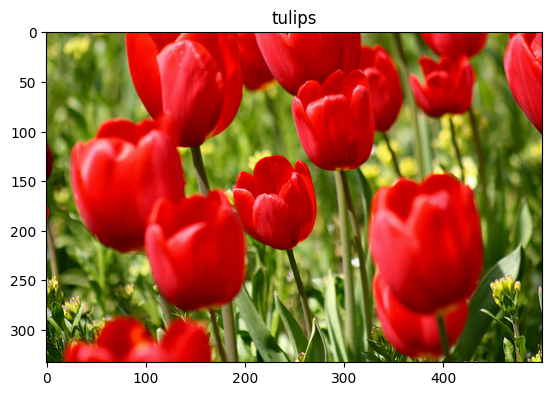

In [8]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers
### Resizing and rescaling

In [10]:
IMG_SIZE = 180

resize_and_rescale = keras.Sequential([
    keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    keras.layers.Rescaling(1./255)
])

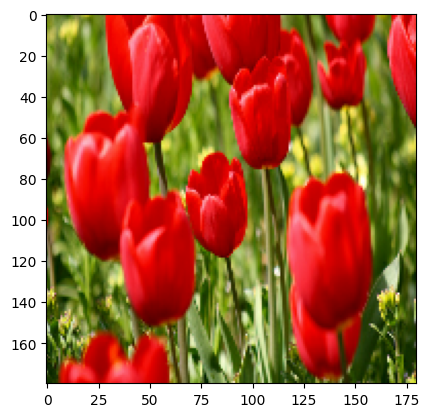

In [11]:
result = resize_and_rescale(image)
plt.imshow(result)

In [12]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())


Min and max pixel values: 0.0 1.0


### Data augmentation

In [13]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2)
])

In [14]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image.shape

TensorShape([1, 333, 500, 3])

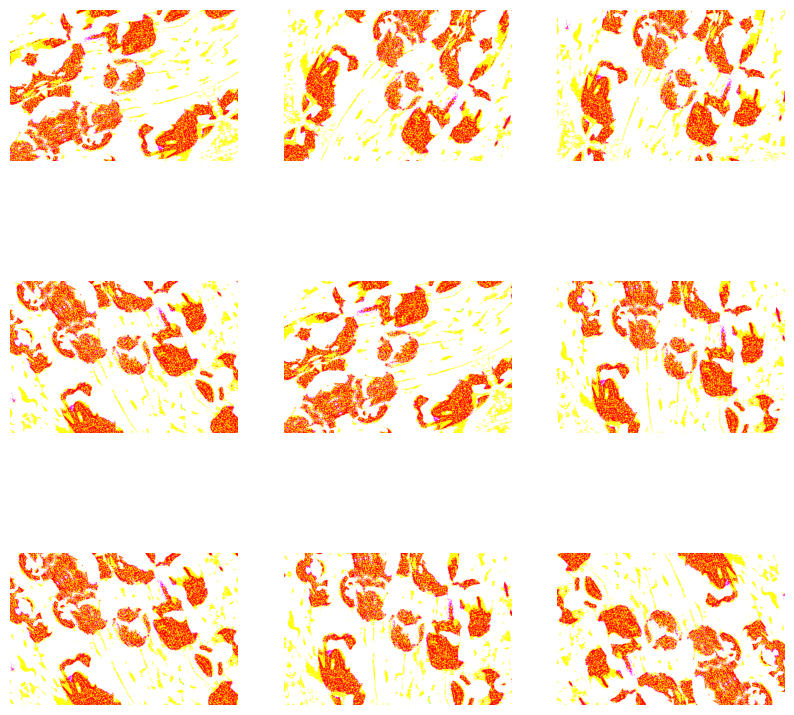

In [15]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Two options to use the Keras preprocessing layers

#### Option 1: Make the preprocessing layers part of your model

In [18]:
model = keras.Sequential([
    # Add the preprocesisng layers you created earlier.
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPooling2D(),
    # Rest of your model
])

There are two important points to be aware of in this case:

- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration
- When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side

#### Option 2: Apply the preprocssing layers to your dataset

In [19]:
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training = True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

- Data augmentatio will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Data.prefetch`, shown below.
- In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

### Apply the preprocessing layers to the datasets

In [20]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment = False):
    # Resiize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls = AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

    # use buffered prefetching on all datsets
    return ds.prefetch(buffer_size = AUTOTUNE)

In [21]:
train_ds = prepare(train_ds, shuffle = True, augment = True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

In [22]:
model = tf.keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

92/92 [==============================] - 133s 1s/step - loss: 1.3795 - accuracy: 0.3951 - val_loss: 1.1527 - val_accuracy: 0.5041


In [25]:
history

In [26]:
loss, acc = model.evaluate(test_ds)
print('Acc', acc)

12/12 [==============================] - 5s 349ms/step - loss: 1.1244 - accuracy: 0.5204
Acc 0.5204359889030457


### Custom data augmentation

#### Using lambda

In [27]:
def random_invert_img(x, p = 0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [28]:
def random_invert(factor = 0.5):
    return keras.layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

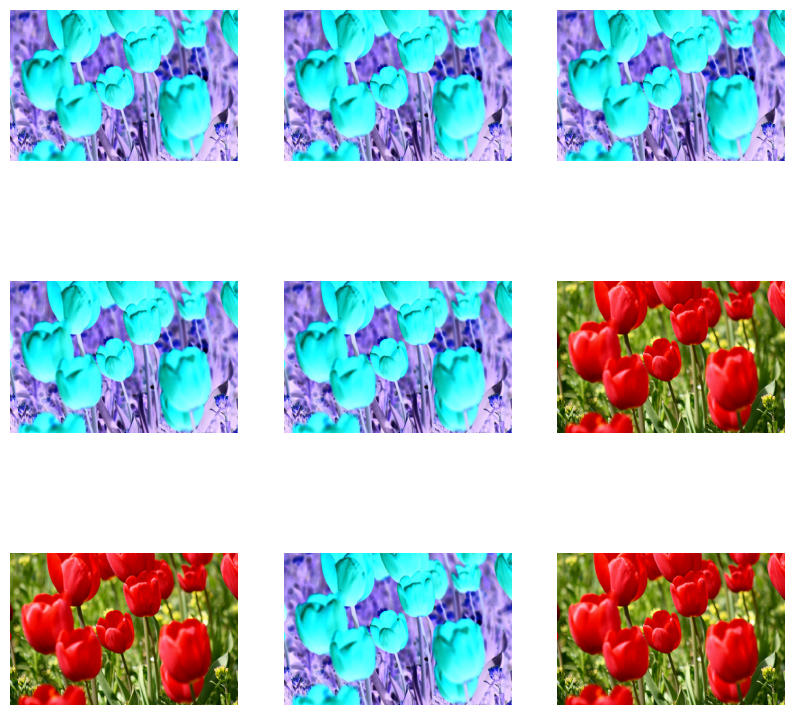

In [29]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

#### Subclassing

In [30]:
class RandomInvert(keras.layers.Layer):
    def __init__(self, factor = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

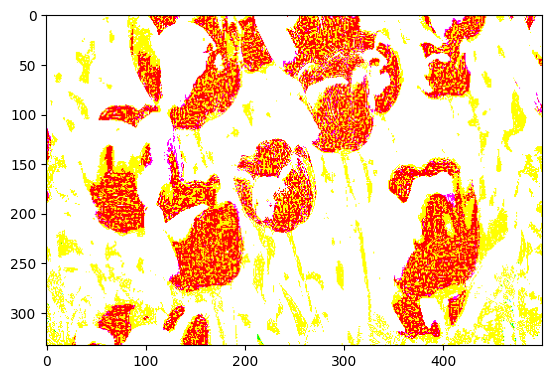

In [32]:
plt.imshow(RandomInvert()(image)[0])